# GridWorld Policy Evaluation

Implementation of Policy Evaluation for a GridWorld environment using Dynamic Programming.

## Problem Description
This reproduces Figure 4.1 from Sutton & Barto's "Reinforcement Learning: An Introduction".
A simple 4x4 GridWorld where:
- Agent can move in 4 directions (north, south, east, west)
- Terminal states: top-left (0,0) and bottom-right (n,n)
- Reward: -1 for every step (incentivizes reaching terminal state quickly)
- Policy: Uniform random (equal probability for all actions)

## Algorithm
- **Policy Evaluation**: Iteratively applies the Bellman expectation equation
  to compute the value function V^π(s) for a given policy π
- Uses synchronous updates (all states updated simultaneously in each sweep)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

In [2]:
# Custom colormap: white to green
W = LinearSegmentedColormap.from_list('custom_blue', ['white', 'lightgreen'], N=256)

In [3]:
# Action mappings: [row_delta, col_delta]
ACTIONS = {
    0: [-1, 0],   # north (up)
    1: [1, 0],    # south (down)
    2: [0, -1],   # west (left)
    3: [0, 1],    # east (right)
}

In [4]:
class GridWorld:
    """
    A simple GridWorld environment for reinforcement learning.
    
    The agent navigates a grid with terminal states at opposite corners.
    Each move incurs a -1 reward, encouraging the agent to reach a terminal
    state as quickly as possible.
    """
    
    def __init__(self, size=4):
        """
        Initialize the GridWorld environment.
        
        Args:
            size (int): Size of the square grid (default: 4x4)
        """
        self.size = size
        self.state_value = np.zeros((size, size))
    
    def reset(self):
        """Reset the value function to zeros."""
        self.state_value = np.zeros((self.size, self.size))
    
    def step(self, state, action):
        """
        Execute one step in the environment.
        
        Args:
            state (tuple): Current state as (row, col)
            action (list): Action as [row_delta, col_delta]
        
        Returns:
            tuple: (next_state, reward)
                - next_state: Resulting state after taking action
                - reward: Immediate reward (0 for terminal, -1 otherwise)
        """
        # Check if current state is terminal
        size = self.size - 1
        if (state == (0, 0)) or (state == (size, size)):
            return state, 0
        
        # Calculate next state
        next_state = (state[0] + action[0], state[1] + action[1])
        reward = -1
        
        # Handle boundary collisions (north-south)
        if next_state[0] < 0 or next_state[0] >= self.size:
            next_state = state
        # Handle boundary collisions (east-west)
        elif next_state[1] < 0 or next_state[1] >= self.size:
            next_state = state
        
        return next_state, reward
    
    def render(self, title=None, k=None):
        """
        Visualize the current state value function as a heatmap.
        
        Args:
            title (str): Optional title for the plot
            k (int): Number of iterations (for automatic title generation)
        
        Returns:
            tuple: (fig, ax) matplotlib figure and axes objects
        """
        size = min(len(self.state_value), 20)
        fig, ax = plt.subplots(figsize=(size, size))
        
        # Set title
        if title is not None:
            ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
        elif k is not None:
            ax.set_title(f'Value Function after k={k} iterations', 
                        fontsize=16, fontweight='bold', pad=20)
        
        # Create heatmap
        sns.heatmap(self.state_value, 
                   annot=True, 
                   fmt=".1f", 
                   cmap=W,
                   linewidths=1, 
                   linecolor="black", 
                   cbar=False,
                   square=True,
                   annot_kws={"size": 12, "weight": "bold"})
        
        ax.set_xlabel('Column', fontsize=12)
        ax.set_ylabel('Row', fontsize=12)
        plt.tight_layout()
        plt.show()
        
        return fig, ax
    
    def bellman_expectation(self, state, action_probs, discount):
        """
        Compute the expected value of a state using the Bellman expectation equation.
        
        V^π(s) = Σ_a π(a|s) * Σ_{s',r} p(s',r|s,a) * [r + γ*V^π(s')]
        
        For this deterministic environment:
        V^π(s) = Σ_a π(a|s) * [r(s,a) + γ*V^π(s')]
        
        Args:
            state (tuple): Current state (row, col)
            action_probs (array): Probability distribution over actions π(a|s)
            discount (float): Discount factor γ
        
        Returns:
            float: Expected value of the state
        """
        value = 0.0
        
        for action_idx, action in ACTIONS.items():
            # Get next state and reward for this action
            next_state, reward = self.step(state, action)
            
            # Apply Bellman expectation equation
            value += action_probs[action_idx] * (
                reward + discount * self.state_value[next_state]
            )
        
        return value


In [5]:
def policy_evaluation(env, policy=None, steps=1, discount=1.0):
    """
    Evaluate a policy using iterative policy evaluation (synchronous).
    
    This function iteratively applies the Bellman expectation equation to
    all states until convergence or for a fixed number of steps.
    
    Args:
        env (GridWorld): The GridWorld environment
        policy (ndarray): Policy π(a|s) as array of shape (rows, cols, actions)
                         If None, uses uniform random policy
        steps (int): Number of evaluation sweeps (default: 1)
        discount (float): Discount factor γ (default: 1.0)
    
    Returns:
        ndarray: The evaluated state value function V^π(s)
    """
    if policy is None:
        # Uniform random policy: equal probability for all actions
        policy = np.ones((*env.state_value.shape, len(ACTIONS))) * 0.25
    
    for k in range(steps):
        # Create temporary array for synchronous updates
        new_values = np.empty_like(env.state_value)
        
        # Update each state
        for i in range(env.size):
            for j in range(env.size):
                state = (i, j)
                # Apply Bellman expectation equation
                new_values[i, j] = env.bellman_expectation(
                    state, policy[i, j], discount
                )
        
        # Update value table (synchronous update)
        env.state_value = new_values
    
    return env.state_value


- **Main Execution**

GridWorld Policy Evaluation - Reproducing Figure 4.1
Sutton & Barto: Reinforcement Learning (2nd Edition)

Environment:
  - Size: 4x4 grid
  - Terminal states: (0,0) and (3,3)
  - Actions: North, South, East, West
  - Reward: -1 per step
  - Policy: Uniform random (0.25 for each action)
  - Discount factor: γ = 1.0

Evaluating policy for k=0 iterations...


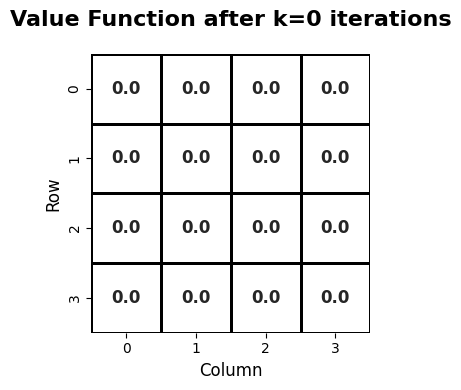


Evaluating policy for k=1 iterations...


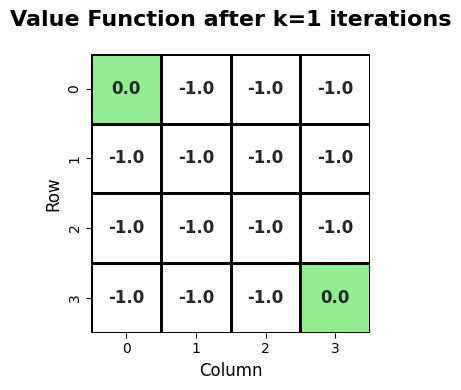

  Non-terminal states - Min: -1.00, Max: -1.00, Mean: -1.00

Evaluating policy for k=2 iterations...


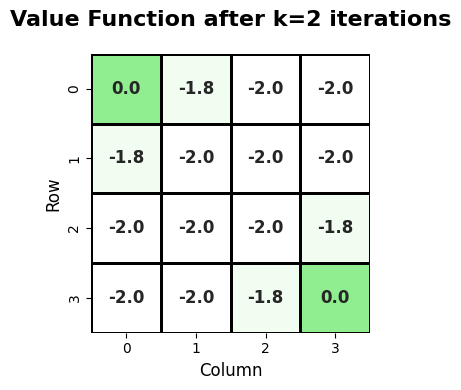

  Non-terminal states - Min: -2.00, Max: -1.75, Mean: -1.93

Evaluating policy for k=3 iterations...


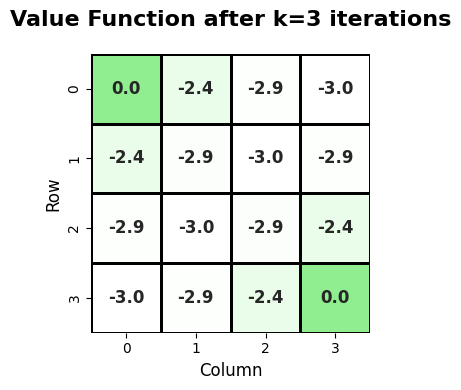

  Non-terminal states - Min: -3.00, Max: -2.44, Mean: -2.80

Evaluating policy for k=10 iterations...


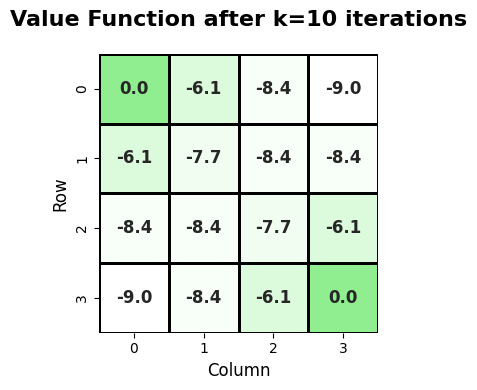

  Non-terminal states - Min: -8.97, Max: -6.14, Mean: -7.73

Evaluating policy for k=100 iterations...


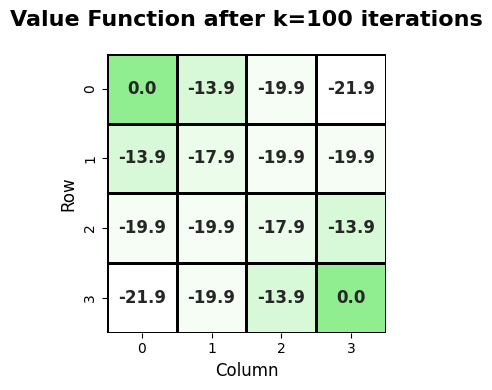

  Non-terminal states - Min: -21.90, Max: -13.94, Mean: -18.21

Policy evaluation complete!


In [6]:
if __name__ == "__main__":
    print("=" * 60)
    print("GridWorld Policy Evaluation - Reproducing Figure 4.1")
    print("Sutton & Barto: Reinforcement Learning (2nd Edition)")
    print("=" * 60)
    print("\nEnvironment:")
    print("  - Size: 4x4 grid")
    print("  - Terminal states: (0,0) and (3,3)")
    print("  - Actions: North, South, East, West")
    print("  - Reward: -1 per step")
    print("  - Policy: Uniform random (0.25 for each action)")
    print("  - Discount factor: γ = 1.0")
    print("=" * 60)
    
    # Evaluate policy at different iteration counts
    iteration_counts = [0, 1, 2, 3, 10, 100]
    
    for k in iteration_counts:
        print(f"\nEvaluating policy for k={k} iterations...")
        
        # Create new environment
        env = GridWorld(size=4)
        
        # Perform policy evaluation
        value_table = policy_evaluation(env, steps=k, discount=1.0)
        
        # Display results
        env.render(k=k)
        
        # Print some statistics
        if k > 0:
            non_terminal_mask = np.ones_like(value_table, dtype=bool)
            non_terminal_mask[0, 0] = False
            non_terminal_mask[3, 3] = False
            
            min_val = value_table[non_terminal_mask].min()
            max_val = value_table[non_terminal_mask].max()
            mean_val = value_table[non_terminal_mask].mean()
            
            print(f"  Non-terminal states - Min: {min_val:.2f}, "
                  f"Max: {max_val:.2f}, Mean: {mean_val:.2f}")
    
    print("\n" + "=" * 60)
    print("Policy evaluation complete!")
    print("=" * 60)